In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import joblib
import os
import sys
import mlflow
from itertools import combinations, product


In [2]:
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [21]:
print(sns.__version__)

0.13.2


The data has been pulled from project A1, so we didn't had to clean, neither do EDA, however author has done some feature selection to training more robust

## Custom Model Building 

In [3]:
class MyRegression:
    
    def __init__(self, regularization: float = None, lr: float = 0.01, method: str = 'mini_batch',
                 weight_init: str = 'zeros', batch_size: int = 64, n_epochs: int = 100, momentum: float = None,
                 poly_degree: int = None, cv: int = 5, log_transform: bool = False, use_mlflow: bool = False):
        self.lr = lr  # learning rate
        self.method = method  # optimization method
        self.weight_init = weight_init  # weight initialization type
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.regularization = regularization  # Ridge or Lasso
        self.momentum = momentum  # momentum coefficient
        self.use_mlflow = use_mlflow
        self.poly_degree = poly_degree
        self.cv = cv  # K-fold validation
        self.weight_decay = 1e-5  # L2 regularization
        self.log_transform = log_transform

        valid_method = ['mini_batch', 'stochastic', 'batch']
        valid_weight = ['normal', 'xavier', 'zeros']
        
        if self.method not in valid_method:
            raise ValueError(f'method must be in {valid_method}')
        if self.weight_init not in valid_weight:
            raise ValueError(f'weight_init must be in {valid_weight}')
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series): ## while deploying application if some error occurs, so to counter that 
            X = X.astype('float').values   
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.astype(float).values

        X = np.array(X).astype('float') 
        y = np.array(y).astype('float')

        if self.log_transform: ## transforming target (y) to log 
            y = np.log1p(y)

        if self.poly_degree is not None:
            X = self._polynomial_features(X)

        intercept = np.ones((X.shape[0], 1)).astype('float') ## adding bias 
        X = np.concatenate((intercept, X), axis=1)

        patience = 4 ## want to check before early stopping to prevent model for gradient problem
        epoch_without_improvement = 0
        self.kfold_train_accuracy_list = []
        self.kfold_train_loss_list = []

        cv = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
            self.W = self.weight_initializer(X.shape[1])

            x_train_cross = X[train_idx]
            y_train_cross = y[train_idx]
            x_val_cross = X[val_idx]
            y_val_cross = y[val_idx]

            self.old_loss = np.inf  

            for epoch in range(self.n_epochs):
                perm_idx = np.random.permutation(len(x_train_cross))
                x_train_cross = x_train_cross[perm_idx]
                y_train_cross = y_train_cross[perm_idx]

                if self.method == 'mini_batch':
                    for i in range(0, len(x_train_cross), self.batch_size):
                        batch_X = x_train_cross[i:i+self.batch_size]
                        batch_y = y_train_cross[i:i+self.batch_size]
                        train_loss, train_accuracy = self._train(batch_X, batch_y)
                elif self.method == 'stochastic':
                    for i in range(x_train_cross.shape[0]):
                        batch_X = x_train_cross[i:i+1]
                        batch_y = y_train_cross[i:i+1]
                        train_loss, train_accuracy = self._train(batch_X, batch_y)
                else:
                    train_loss, train_accuracy = self._train(x_train_cross, y_train_cross)

                self.kfold_train_accuracy_list.append(train_accuracy)
                self.kfold_train_loss_list.append(train_loss)

                y_hat_val = self._predict(x_val_cross, is_train=True)
                val_loss, val_accuracy = self.mse(y_val_cross, y_hat_val), self.r2_score(y_val_cross, y_hat_val)
    
                if np.isclose(self.old_loss, val_loss, atol=1e-3):
                    epoch_without_improvement += 1 
                    if epoch_without_improvement >= patience: 
                        print('early stopping')
                        break
                else: 
                    epoch_without_improvement = 0
    
                self.old_loss = val_loss

            print(f"{fold} --> train_loss: {np.mean(self.kfold_train_loss_list):.3f} | train_accuracy: {np.mean(self.kfold_train_accuracy_list):.4f} | val_loss: {val_loss:.4f} | val_accuracy: {val_accuracy:.4f}")

    def _predict(self, X, is_train=False):
        if isinstance(X, (pd.DataFrame, pd.Series)): ## this are for xtest 
            X = X.astype('float').values
        elif isinstance(X, np.ndarray):
            X = np.array(X).astype('float')

        if not is_train and self.poly_degree is not None:
            X = self._polynomial_features(X)
            
        if X.shape[1] == self.W.shape[0] - 1:  # Check if bias is missing
            intercept = np.ones((X.shape[0], 1)).astype('float')
            X = np.concatenate((intercept, X), axis=1)
        
        return np.dot(X, self.W.reshape(-1, 1)).flatten()

    def _train(self, X, y):
        y_hat = self._predict(X, is_train=True)
        
        m = X.shape[0]

        grad = (1 / m) * np.dot(X.T, (y_hat - y).reshape(-1, 1))

        grad += self.weight_decay * self.W.reshape(-1, 1) 
        
        grad = np.clip(grad, -5.0, 5.0) ## for gradient explosion

        if self.momentum is not None:
            if not hasattr(self, 'velocity'):
                self.velocity = np.zeros_like(self.W)
            self.velocity = self.momentum * self.velocity - self.lr * grad.flatten()  # Ensure 1D shape
            self.W += self.velocity.flatten()
        else:
            self.W -= self.lr * grad.flatten() 

        if np.isnan(self.W).any() or np.isinf(self.W).any():
            print("Warning: NaN or Inf detected in weights!")
            self.W = np.where(np.isnan(self.W) | np.isinf(self.W), np.random.randn(*self.W.shape) * 0.01, self.W)

        return self.mse(y, y_hat), self.r2_score(y, y_hat)

    def mse(self, ytrue, ypred):
        return np.sum((ypred - ytrue) ** 2) / ytrue.shape[0]

    def r2_score(self, ytrue, ypred):
        rss = np.sum((ytrue - ypred) ** 2)
        tss = np.sum((ytrue - np.mean(ytrue)) ** 2)
        return 1 - (rss / tss)

    def weight_initializer(self, num_features):
        if self.weight_init == 'zeros':
            return np.zeros(num_features).astype('float')
        elif self.weight_init == 'xavier':
            limit = 1 / np.sqrt(num_features)
            return np.random.uniform(-limit, limit, size=num_features).astype('float')
        else:
            return np.random.randn(num_features).astype('float') * 0.01
        
    def _polynomial_features(self, X):  
    
        if self.poly_degree is None:
            return X
        
        X = np.array(X, dtype='float')  # Ensure NumPy format
        n_samples, n_features = X.shape
        poly_features = [X]
    
        # Add higher-degree features (x^2, x^3, etc.)
        for degree in range(2, self.poly_degree + 1):
            poly_features.append(X ** degree)
    
        # Add interaction terms for degree = 2  ## tried combination but it was too much for weights, exploding everywhere ..!!
        # if self.poly_degree == 2:
        #     interaction_terms = [np.prod(X[:, np.array(combo)], axis=1) for combo in combinations(range(n_features), 2)]
        #     return np.column_stack(poly_features + interaction_terms)
    
        return np.concatenate(poly_features, axis=1)
   
    def _coef(self):
        """Returns all weights except the intercept (bias)."""
        return self.W[1:]  
    
    def _bias(self):
        """Returns the bias term."""
        return self.W[0]
    
    def plot_feature_importance(self, feature_names=None):
        
        # Ensure weights are NumPy arrays
        feature_importance = np.array(self._coef())  
    
        # If feature names are not provided, generate default names
        num_features = len(feature_importance)
        if feature_names is None:
            feature_names = [f'Feature {i+1}' for i in range(num_features)]
    
        # Adjust feature names for polynomial features (No interaction terms now)
        expanded_feature_names = self.get_expanded_feature_names(feature_names)
    
        # Dictionary to sum importance across polynomial degrees
        feature_weight_dict = {name: 0 for name in expanded_feature_names}
    
        # Aggregate absolute importance values for polynomial terms
        for name, weight in zip(expanded_feature_names, feature_importance):
            feature_weight_dict[name] += abs(weight)  # Sum absolute importance
    
        # Convert to DataFrame and sort by importance
        sorted_features = sorted(feature_weight_dict.items(), key=lambda x: x[1], reverse=True)
        coefs_df = pd.DataFrame(sorted_features, columns=["Feature", "Importance"])
    
    
        # Normalize feature importance for visualization
        max_importance = coefs_df["Importance"].max()
        min_importance = coefs_df["Importance"].min()
        
        if max_importance > min_importance:  
            normalized_importance = (coefs_df["Importance"] - min_importance) / (max_importance - min_importance)
            color_indices = (normalized_importance * 255).astype(int)  # Convert to color scale (0-255)
        else:
            color_indices = np.full(len(coefs_df), 128)  # Default middle shade if importance is constant
    
        colors = [plt.cm.Greens(idx / 255) for idx in color_indices]
    
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x=coefs_df["Importance"], y=coefs_df["Feature"], palette=colors) 
    
        max_importance = np.max(np.abs(coefs_df["Importance"]))
    
        # Add data labels with proper positioning
        for index, value in enumerate(coefs_df["Importance"]):
            label = f"{value:.4f}"
            if abs(value) < 0.05 * max_importance:  # If bar is **too short**
                ax.text(value + (0.05 * max_importance), index, label, 
                        va='center', ha='left', fontsize=12, color='black', fontweight='bold')  
            else:
                ax.text(value * 0.95, index, label, 
                        va='center', ha='right' if value > 0 else 'left', fontsize=9, color='white', fontweight='bold')  
    
        # Add labels and title
        plt.xlabel('Feature Importance', fontsize=14)
        plt.ylabel('Features', fontsize=14)
        plt.title('Feature Importance Plot', fontsize=16)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
    
        # Show the plot
        plt.show()
        
    def get_expanded_feature_names(self, feature_names):
        
        if self.poly_degree is None or self.poly_degree == 1:
            return feature_names  # No transformation, return as is
    
        expanded_feature_names = []
        
        # Generate polynomial feature names (x, x^2, x^3, ...)
        for degree in range(1, self.poly_degree + 1):
            expanded_feature_names.extend([f"{col}^{degree}" for col in feature_names])
    
        return expanded_feature_names

In [4]:
class L1Penalty:
    """
    Implements L1 (Lasso) regularization.
    """
    def __init__(self, l):
        self.l = l 

    def __call__(self, W):
        return self.l * np.sum(np.abs(W))
    
    def derivation(self, W):
        return self.l * np.sign(W)


class L2Penalty:
    """
    Implements L2 (Ridge) regularization.
    """
    def __init__(self, l):
        self.l = l

    def __call__(self, W):
        return self.l * np.sum(np.square(W))

    def derivation(self, W):
        return self.l * 2 * W


class LassoRegression(MyRegression):
    """
    Implements Lasso Regression using L1 Regularization.
    """
    def __init__(self, l=0.1, **kwargs):
        super().__init__(regularization=L1Penalty(l=l), **kwargs)


class RidgeRegression(MyRegression):
    """
    Implements Ridge Regression using L2 Regularization.
    """
    def __init__(self, l=0.1, **kwargs):
        super().__init__(regularization=L2Penalty(l=l), **kwargs)

## Data Preprocessing

In [5]:
df = pd.read_csv('Out_287.csv')

In [6]:
df

,Unnamed: 0,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,0,BMW,2017,3200000,13663,Diesel,Dealer,Automatic,1,22.69,1995.0,190.00,5.0
1,1,BMW,2012,900000,155000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,4.0
2,2,BMW,2017,2950000,39000,Diesel,Dealer,Automatic,1,19.59,1995.0,187.74,5.0
3,4,BMW,2009,1100000,60000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,5.0
4,5,BMW,2012,1100000,80000,Diesel,Individual,Automatic,2,16.07,1995.0,181.00,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6658,8023,Tata,2018,459999,35000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0
6659,8024,Tata,2017,400000,53000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0
6660,8025,Tata,2015,450000,40000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0
6661,8026,Tata,2015,500000,20000,Petrol,Individual,Manual,1,17.57,1193.0,88.70,5.0


In [7]:
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Identify categorical and numerical features
categorical_features = ['fuel', 'seller_type', 'transmission']
numerical_features = ['year', 'km_driven', 'owner', 'mileage', 'engine', 'max_power', 'seats', 'brand_encoded']


X = df.drop(columns=['selling_price'])
y = df['selling_price']

# Train-test split **AFTER dropping target**
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Mean Encoding for `brand`
brand_means = df_train.join(y_train).groupby('brand')['selling_price'].mean()

df_train['brand_encoded'] = df_train['brand'].map(brand_means)
df_test['brand_encoded'] = df_test['brand'].map(brand_means)

# Fill NaN in test set (brands not seen in training)
df_test['brand_encoded'] = df_test['brand_encoded'].fillna(brand_means.mean())

# Drop the original `brand` column
df_train.drop(columns=['brand'], inplace=True)
df_test.drop(columns=['brand'], inplace=True)


categorical_features = ['fuel', 'seller_type', 'transmission']
numerical_features = ['year', 'km_driven', 'owner', 'mileage', 'engine', 'max_power', 'seats', 'brand_encoded']
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # Drop first to avoid multicollinearity
df_train_encoded = encoder.fit_transform(df_train[categorical_features])
df_test_encoded = encoder.transform(df_test[categorical_features])

# Convert to DataFrame
train_encoded_df = pd.DataFrame(df_train_encoded, columns=encoder.get_feature_names_out(categorical_features))
test_encoded_df = pd.DataFrame(df_test_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and replace with encoded
df_train.drop(columns=categorical_features, inplace=True)
df_test.drop(columns=categorical_features, inplace=True)

df_train = pd.concat([df_train.reset_index(drop=True), train_encoded_df.reset_index(drop=True)], axis=1)
df_test = pd.concat([df_test.reset_index(drop=True), test_encoded_df.reset_index(drop=True)], axis=1)

###Scaling for Numerical Features
scaler = StandardScaler()
df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])  # Use the same scaler!

# Final processed features
X_train = df_train.values
X_test = df_test.values

###  Apply Log Transformation to `y`
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5330, 12), (1333, 12), (5330,), (1333,))

In [8]:
X_train

array([[ 0.35871623, -0.17436282, -0.68242219, ...,  1.        ,
         0.        ,  1.        ],
       [-0.93192608,  1.81913291,  0.67833736, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.6168447 ,  0.54756156, -0.68242219, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.15754069, -0.3343347 , -0.68242219, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.35871623, -0.99062959, -0.68242219, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.35871623,  0.95774587, -0.68242219, ...,  1.        ,
         0.        ,  1.        ]], shape=(5330, 12))

In [12]:
os.environ["LOGNAME"] = "st124783_darth_binit"

## Grid Search and registering in Ml Flow

In [14]:
mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("A2_st124783_Chaky_car")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1738745213449, experiment_id='1', last_update_time=1738745213449, lifecycle_stage='active', name='A2_st124783_Chaky_car', tags={}>

In [ ]:
regs = ["MyRegression", "RidgeRegression", "LassoRegression"]
lr = [0.01, 0.001, 0.0001]
weights = ['zeros', 'xavier', 'normal']
methods = ["batch","mini_batch", "stochastic"]
momentum = [None, 0.8]
degrees = [None, 2]  # Polynomial degrees

# Initialize best models for tracking
best_model_r2, best_r2, best_params_r2 = None, float('-inf'), None
best_model_mse, best_mse, best_params_mse = None, float('inf'), None

def run_experiment(reg, method, poly_degree, weight, momentum, lr, cv, use_mlflow):
    """Runs an ML experiment, logs results in MLflow, and tracks best models."""
    global best_model_r2, best_r2, best_model_mse, best_mse,  best_params_r2, best_params_mse# Track best models

    poly_msg = "Polynomial" if poly_degree is not None else "Linear"
    momentum_msg = "Momentum is used" if momentum is not None else "Momentum is not used"

    params = {
        "method": method, "lr": lr, "weight_init": weight, "poly_degree": poly_degree,
        "momentum": momentum, "cv": cv, "use_mlflow": use_mlflow}

    print(f" Running {reg} | {method} | {poly_msg} | {weight} | {momentum_msg} | LR: {lr}")

    # Get Model Class
    type_of_regression = str_to_class(reg)    
    model = type_of_regression(**params)

    with mlflow.start_run(run_name=f"method-{method}-lr-{lr}-reg-{reg}-poly-{poly_msg}-momentum-{momentum_msg}-weight-{weight}", nested=True):

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model._predict(X_test)
        
        test_loss = model.mse(y_test, y_pred)
        test_r2 = model.r2_score(y_test, y_pred)

        # Log hyperparameters & metrics
        mlflow.log_params(params)  
        mlflow.log_metrics({"test_mse": test_loss, "test_r2": test_r2})

        # Save Model Signature
        signature = mlflow.models.infer_signature(X_train, model._predict(X_train))
        mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

        print(f"✅ Fold: {method} | Model: {reg} | MSE: {test_loss:.4f} | R²: {test_r2:.4f}")

        # Track the Best Model Based on MSE (LOWER IS BETTER)
        if test_loss < best_mse:
            best_mse = test_loss
            best_model_mse = model
            best_params_mse = params 

        # Track the Best Model Based on R² Score (HIGHER IS BETTER)
        if test_r2 > best_r2:
            best_r2 = test_r2
            best_model_r2 = model
            best_params_r2 = params  # Save best hyperparameters for R²


# Iterate over all hyperparameter combinations
combinations_ = product(regs, methods, degrees, weights, momentum, lr)

# Run all experiments
for reg, method, poly_degree, weight, momentum, lr in combinations_:
    run_experiment(reg, method, poly_degree, weight, momentum, lr, cv=5, use_mlflow=True)

#Final Results: Best Models Based on MSE & R² Score
print(f"Best Model by R² Score: {best_model_r2} with R² Score: {best_r2:.4f}")
print(f"Best Model by MSE: {best_model_mse} with MSE: {best_mse:.4f}")

mlflow.end_run()

In [55]:
print('best model r2: ', best_model_r2)
print('='*100)
print('best model ms2: ', best_model_mse)
print('='*100)
print('best_mse_loss: ', best_params_r2)
print('='*130)
print('best_param_mse: ', best_params_mse)

best model r2:  <__main__.RidgeRegression object at 0x13fa6cc80>
best model ms2:  <__main__.RidgeRegression object at 0x13fa6cc80>
best_mse_loss:  {'method': 'mini_batch', 'lr': 0.01, 'weight_init': 'xavier', 'poly_degree': 2, 'momentum': 0.8, 'cv': 5, 'use_mlflow': True}
best_param_mse:  {'method': 'mini_batch', 'lr': 0.01, 'weight_init': 'xavier', 'poly_degree': 2, 'momentum': 0.8, 'cv': 5, 'use_mlflow': True}


In [12]:
model_R = RidgeRegression(cv=7, weight_init='xavier', lr=0.01,  method='mini_batch', poly_degree=2, momentum=0.8)

In [19]:
model_R.fit(X_train, y_train)

0 --> train_loss: 0.667 | train_accuracy: -0.1085 | val_loss: 0.0931 | val_accuracy: 0.8297
1 --> train_loss: 0.512 | train_accuracy: 0.0631 | val_loss: 0.5314 | val_accuracy: 0.0481
2 --> train_loss: 0.511 | train_accuracy: 0.0306 | val_loss: 0.0856 | val_accuracy: 0.8420
3 --> train_loss: 0.488 | train_accuracy: 0.0432 | val_loss: 0.0944 | val_accuracy: 0.8320
4 --> train_loss: 0.454 | train_accuracy: 0.1088 | val_loss: 0.0862 | val_accuracy: 0.8417
5 --> train_loss: 0.444 | train_accuracy: 0.1454 | val_loss: 0.0766 | val_accuracy: 0.8617
6 --> train_loss: 0.426 | train_accuracy: 0.1821 | val_loss: 0.0819 | val_accuracy: 0.8526


#### Ridge looks more stable in terms of loss reduction and also in terms of accuracy in both training and validation 

In [18]:
model_L = LassoRegression(cv=7, weight_init='xavier', lr=0.01,  method='mini_batch', poly_degree=2, momentum=0.8)
model_L.fit(X_train, y_train)

0 --> train_loss: 0.348 | train_accuracy: 0.3634 | val_loss: 0.0798 | val_accuracy: 0.8539
1 --> train_loss: 0.368 | train_accuracy: 0.2854 | val_loss: 0.0829 | val_accuracy: 0.8515
2 --> train_loss: 0.426 | train_accuracy: 0.1560 | val_loss: 0.0827 | val_accuracy: 0.8473
3 --> train_loss: 0.416 | train_accuracy: 0.1733 | val_loss: 0.0956 | val_accuracy: 0.8300
4 --> train_loss: 0.396 | train_accuracy: 0.2117 | val_loss: 0.3382 | val_accuracy: 0.3792
5 --> train_loss: 0.402 | train_accuracy: 0.2065 | val_loss: 0.2441 | val_accuracy: 0.5595
6 --> train_loss: 0.389 | train_accuracy: 0.2081 | val_loss: 0.1383 | val_accuracy: 0.7510


In [28]:
print('model_L: Coef', model_R._coef())
print('='*100)
print('model_R: Coef', model_L._coef())

model_L: Coef [ 0.40863739 -0.04156177 -0.04281289  0.07035221  0.05547425  0.33683872
  0.09458995  0.22265857  0.00648576 -0.1379079   0.07093793  0.08612269
  0.0245084   0.01121755  0.00540981 -0.00984661  0.01297824 -0.06302001
 -0.02220666 -0.05055066 -0.16112152  0.09332943  0.18660732 -0.19209473]
model_R: Coef [ 0.40444856 -0.03686537 -0.03746032  0.06791344  0.05985427  0.33512169
  0.09035153  0.23459641 -0.14091792 -0.15569431  0.15447293 -0.22372469
  0.00655812  0.05484538 -0.00667611 -0.03182224 -0.00386638 -0.04803368
 -0.02532472 -0.02684442  0.00077207  0.09624501  0.06210705  0.10080709]


/var/folders/8j/ndxdwkv11mg2yfgyrfgqxrwr0000gn/T/ipykernel_5602/4265555425.py:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=coefs_df["Importance"], y=coefs_df["Feature"], palette=colors)


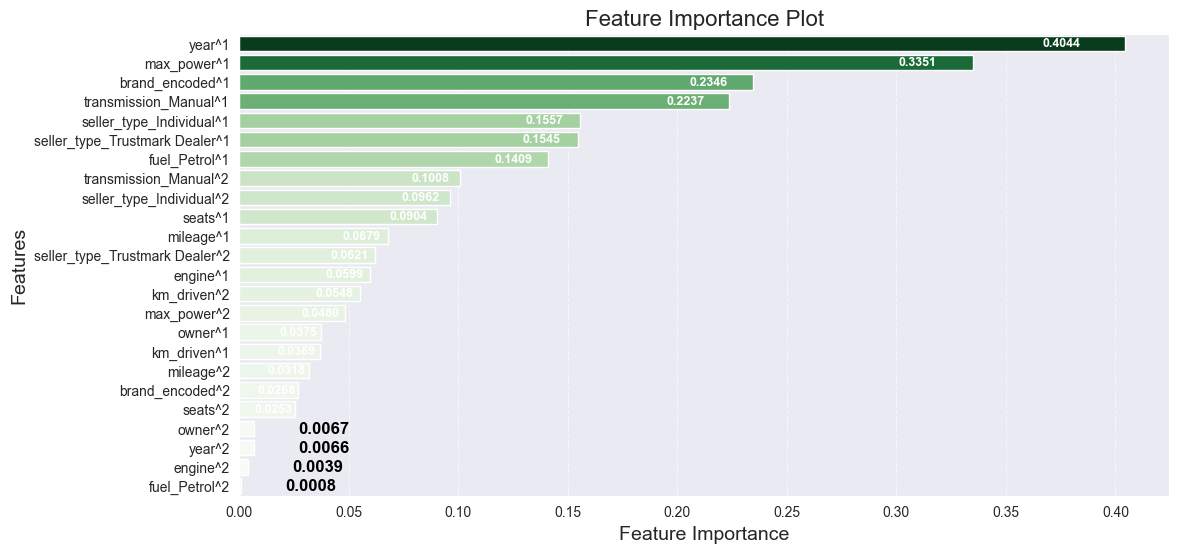

In [29]:
model_L.plot_feature_importance(df_train.columns)

## Inference

In [ ]:
val = np.array(['Audi', 2015, 51000, 'Diesel', 'Trustmark Dealer', 'Automatic', 1, 20, 2000, 160, 7])
# Convert input to a DataFrame
columns = ['brand', 'year', 'km_driven', 'fuel', 'seller_type',
           'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats']
val = pd.DataFrame([val], columns=columns)
print(val)
# Mean Encoding for 'brand'
val['brand_encoded'] = val['brand'].map(brand_means)

# Handle unseen brands
if val['brand_encoded'].isnull().any():
    val['brand_encoded'] = val['brand_encoded'].fillna(brand_means.mean())

# Drop original 'brand' column
val.drop(columns=['brand'], inplace=True)

# One-Hot Encoding for Categorical Features
val_encoded = encoder.transform(val[categorical_features])
val_encoded_df = pd.DataFrame(val_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Drop categorical columns from `val`
val.drop(columns=categorical_features, inplace=True)

#  Merge Encoded Categorical Features Back
val = pd.concat([val.reset_index(drop=True), val_encoded_df.reset_index(drop=True)], axis=1)
print(val)
# Scale Numerical Features Without Overwriting `val`
val[numerical_features] = scaler.transform(val[numerical_features])

print(val)
# Get Final Processed Features
val_final = val.values


predicted_price = np.expm1(model_L._predict(val_final))

print(f"Predicted Price: {predicted_price.item():,.2f}")

## Pickle to transfer the model 

In [36]:
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [37]:
joblib.dump(model_L , 'myregression_lasso.pkl' )

['myregression_lasso.pkl']

In [46]:
joblib.dump(scaler, 'scaler1.pkl')

['scaler1.pkl']

# Findings

#### 1. First, the author has created two version of working file, one using torch tensor and other numpy. Since author used 32 float default as a precision point in torch, numpy has an edge here with 64 floating precision. Basically idea was to use torch so that we can access gpu of arm based m3 chip. Later author found out too tedious but learned many thing in process, in  a smaller dataset like our Car, cpu performs way better..!! 
#### 2. Author checked the statistical features of data with km being right skewed --> applied log transform | and kms and max_driven being slightly left skewed so in tensor file author did seperate log transform and used minmax scaler for not so normal dist. data. But since we are using polynomial in our case raising to power of 2, author feels non linearity can be captured. So in this working file he didn't seperately transform any data.
#### 3. About the feature selection, author used two method one is Embedded method where author used sklearn regression model to see which are the important features so only [7,9,11] were shown and other he used statistical F test to determine feature importance where only 3rd and 9th feature were excluded. Author tried to train model excluding those features but got no improved performance.
#### 4. Author found out, there is gradient exploding problem in stochastic, as weights are updated per sample/row so it created a lot of problem while training the data, even in batch, mini_batch, we had some explosion so author decided to use clipping mechanism to limit the range of the wieght and also add weight decay. A better solution later author found out could be using some other mechanism of adam, rmsprop which are yet be learnt. 
#### 5. Regularization definetly hepls in stabilizing the model, the overfitting is largely reduced, model starts to generalize the data points, also with smaller learning rates it the training happens much slower as weights are updated accordingly. So in stochastic having higher learning rate does helps to prevent weights from explosion.
#### 6. The xavier and normal weight intialization definetly helped in terms of vanishing gradients problem and slow convergence to optimal weights. 
#### 7. The momentum just speeds up the convergence process we can see that while training model too, normally within 2 folds there was a big drop in mse  
#### 8. Want to ask Professor... why does loss and r2_score suddenly get spiked after 5 or 6 fold, is it overfitting and not generalizing the data points  